In [10]:
import torch
from torch import nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from botorch.models.gpytorch import GPyTorchModel
from botorch.models import ModelListGP
from botorch.fit import fit_gpytorch_mll, fit_gpytorch_mll_torch
from botorch.acquisition.multi_objective import qLogExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions import FastNondominatedPartitioning
from botorch.optim import optimize_acqf
from botorch.utils.multi_objective import is_non_dominated
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import SumMarginalLogLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, ConstantKernel
from gpytorch.constraints import Interval
from gpytorch.models import ExactGP, ApproximateGP
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from botorch.test_functions import BraninCurrin, ZDT3
from botorch.test_functions.multi_objective import MultiObjectiveTestProblem
from botorch.utils import draw_sobol_samples
from sklearn.preprocessing import StandardScaler

In [5]:
class FeatureExtractor(nn.Sequential):
    def __init__(self, input_dim, hidden_dim=32, n_hidden=1, output_dim=None):
        super().__init__()
        if output_dim is None: output_dim = input_dim
        self.output_dim = output_dim
        fc1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_normal_(fc1.weight, nonlinearity='tanh')
        nn.init.zeros_(fc1.bias)
        self.add_module("fc1", fc1)
        self.add_module("tanh", nn.Tanh())

        for i in range(n_hidden):
            dense = nn.Linear(hidden_dim, hidden_dim)
            nn.init.kaiming_normal_(dense.weight, nonlinearity='tanh')
            nn.init.zeros_(dense.bias)
            self.add_module("dense" + str(i), dense)
            self.add_module("tanh", nn.Tanh())

        fc2 = nn.Linear(hidden_dim, output_dim)
        nn.init.kaiming_normal_(fc2.weight, nonlinearity='tanh')
        nn.init.zeros_(fc2.bias)
        self.add_module("fc2", fc2)


class DKLGP(ExactGP, GPyTorchModel):
    _num_outputs = 2
    def __init__(self, train_x, train_y, feature_extractor, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.feature_extractor = feature_extractor
        self.likelihood = likelihood

        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=self.feature_extractor.output_dim, lengthscale_constraint=Interval(1e-3, 1e3, initial_value=torch.ones(self.feature_extractor.output_dim, dtype=torch.float64))))# + ConstantKernel()

    def forward(self, x):
        x = self.feature_extractor(x)  # NOTE: try commenting out this line for a normal GP and leave it uncommented for deep kernel learning
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)


In [ ]:
class Kurasawe(MultiObjectiveTestProblem):
    dim = 3
    _bounds = [(-5.0, 5.0), (-5.0, 5.0), (-5.0, 5.0)]
    _ref_point = [-25.0, -25.0]
    continuous_inds = list(range(3))

    def __init__(self, noise_std = None, negate = False, dtype = torch.double):
        super().__init__(noise_std=noise_std, negate=negate, dtype=dtype)
    
    def _evaluate_true(self, X):
        f1 = -10 * torch.exp(-0.2 * torch.sqrt(X[:, 0] ** 2 + X[:, 1] ** 2)) + -10 * torch.exp(-0.2 * torch.sqrt(X[:, 1] ** 2 + X[:, 2] ** 2))
        f2 = torch.sum(torch.abs(X) ** 0.8 + 5 * torch.sin(X ** 3), dim=1)
        f_X = torch.stack([f1, f2], dim=-1)
        return f_X


# problem = BraninCurrin(0.0, negate=True)
# problem = ZDT3(dim=2, num_objectives=2, noise_std=0.0, negate=True)
problem = Kurasawe(0.0, negate=True)



torch.manual_seed(1)
device = torch.device("cpu")
learning_rate = 0.01  # NOTE: if the model gives an error or does not find the pareto front, decrease learning rate

train_x = draw_sobol_samples(problem.bounds, 10, 1).squeeze(1).to(torch.float64)
train_y = problem(train_x)
transformer = StandardScaler()
train_y = torch.tensor(transformer.fit_transform(train_y))

models = []
for i in range(train_y.size(1)):
    feature = DKLGP(train_x, train_y[:, i], FeatureExtractor(input_dim=problem.dim, hidden_dim=32, n_hidden=2, output_dim=16).to(torch.float64), GaussianLikelihood().to(torch.float64)).to(torch.float64)
    models.append(feature)
model = ModelListGP(*models).to(torch.float64)
mll = SumMarginalLogLikelihood(model.likelihood, model)
model.train()
optimizer = Adam(model.parameters(), lr=learning_rate)
fit_gpytorch_mll_torch(mll, optimizer=optimizer)


for i in range(50):
    ref_point = train_y.min(dim=0).values
    partitioning = FastNondominatedPartitioning(ref_point=ref_point, Y=train_y)
    EI = qLogExpectedHypervolumeImprovement(model=model, ref_point=ref_point, partitioning=partitioning)

    candidate, _ = optimize_acqf(EI, bounds=problem.bounds, q=1, num_restarts=5, raw_samples=20)

    train_x = torch.cat([train_x, candidate])
    train_y = torch.tensor(transformer.fit_transform(problem(train_x)))

    model.models[0].set_train_data(train_x, train_y[:, 0], strict=False)
    model.models[1].set_train_data(train_x, train_y[:, 1], strict=False)
    model.train()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    fit_gpytorch_mll_torch(mll, optimizer=optimizer)  # NOTE: torch optimizers are A LOT more stable with deep kernel learning than scipy optimizers

    print(f"Iter {i + 1}: Latest value = {train_y[-1, :].numpy()} - Candidate: {candidate.flatten().numpy()}")


Iter 1: Latest value = [ 1.71376474 -0.41151113] - Candidate: [-0.39241118  1.05242523  2.32428662]
Iter 2: Latest value = [ 0.48447136 -0.11831575] - Candidate: [ 3.83938925 -1.26646697 -1.65390246]
Iter 3: Latest value = [-0.01952653 -0.06523664] - Candidate: [ 4.28286525 -1.88545256 -1.80983466]
Iter 4: Latest value = [1.31513719 1.06826091] - Candidate: [ 2.76924055 -0.75561678 -1.14473912]
Iter 5: Latest value = [ 0.0974113  -1.91376794] - Candidate: [ 4.48354593  0.57400673 -2.21924613]
Iter 6: Latest value = [ 0.267131   -0.86925455] - Candidate: [ 4.3495064  -1.72107838 -0.77435251]
Iter 7: Latest value = [ 0.55178047 -1.50453174] - Candidate: [-2.24386289 -1.58256572  2.33942156]
Iter 8: Latest value = [-0.94681048  0.33961524] - Candidate: [ 3.82713452 -2.25471468 -4.01115579]
Iter 9: Latest value = [ 1.83675209 -0.79171976] - Candidate: [-0.27401007  0.9203713   2.01898631]
Iter 10: Latest value = [1.80052545 1.45163409] - Candidate: [-0.34541328  0.5257908   2.25091043]
Ite

In [4]:
ScaleKernel(RBFKernel())

ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)

In [22]:
if problem.dim == 2:
    n_points = 500
    x1 = torch.linspace(*problem.bounds.T[0], n_points)
    x2 = torch.linspace(*problem.bounds.T[1], n_points)
    X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
    X = torch.stack([X1.flatten(), X2.flatten()], dim=-1).double()
elif problem.dim == 3:
    n_points = 100
    x1 = torch.linspace(*problem.bounds.T[0], n_points)
    x2 = torch.linspace(*problem.bounds.T[1], n_points)
    x3 = torch.linspace(*problem.bounds.T[2], n_points)
    X1, X2, X3 = torch.meshgrid(x1, x2, x3, indexing='ij')
    X = torch.stack([X1.flatten(), X2.flatten(), X3.flatten()], dim=-1).double()
else:
    raise NotImplementedError()

old_noise = problem.noise_std
problem.noise_std = 0.0  # make pareto fron predictions with zero noise
Y = problem(X)
problem.noise_std = old_noise
pareto_mask = is_non_dominated(Y)
pareto_front = Y[pareto_mask]
pareto_front_X = X[pareto_mask]

[]

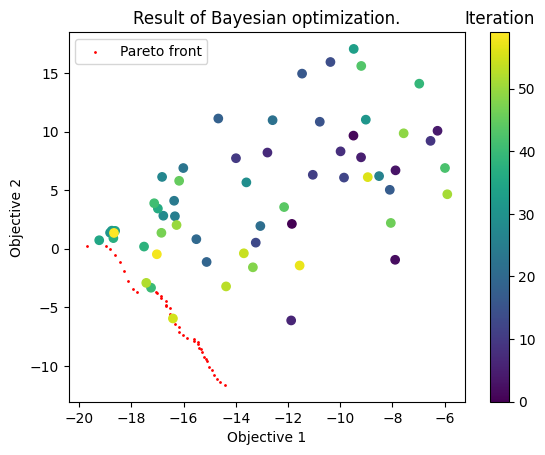

In [57]:
y = transformer.inverse_transform(train_y)
color = torch.arange(0, len(train_y), 1)
plt.scatter(-pareto_front[:, 0], -pareto_front[:, 1], alpha=1, color='red', s=1, label="Pareto front")
plt.scatter(-y[:, 0], -y[:, 1], c=color)
cbar = plt.colorbar()
cbar.ax.set_title("Iteration")
plt.legend()
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.title("Result of Bayesian optimization.")
plt.plot()

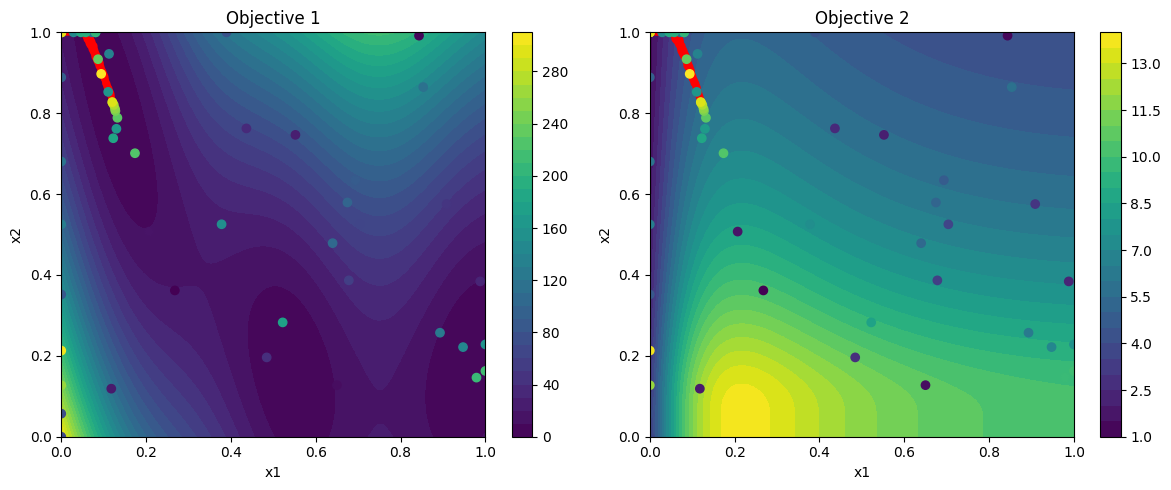

In [ ]:
N = 100
x1 = torch.linspace(problem.bounds[0, 0], problem.bounds[1, 0], N)
x2 = torch.linspace(problem.bounds[0, 1], problem.bounds[1, 1], N)
X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

X = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)
Y = problem(X).detach()

Z1 = -Y[:, 0].reshape(N, N)
Z2 = -Y[:, 1].reshape(N, N)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

cs1 = axs[0].contourf(X1.numpy(), X2.numpy(), Z1.numpy(), levels=30, cmap='viridis')
axs[0].scatter(pareto_front_X[:, 0], pareto_front_X[:, 1], c='red', s=10, label='Pareto-optimal inputs')
axs[0].scatter(train_x[:, 0], train_x[:, 1], c=color, label="Sampled points")
axs[0].set_title("Objective 1")
axs[0].set_xlabel("x1")
axs[0].set_ylabel("x2")
fig.colorbar(cs1, ax=axs[0])

cs2 = axs[1].contourf(X1.numpy(), X2.numpy(), Z2.numpy(), levels=30, cmap='viridis')
axs[1].scatter(pareto_front_X[:, 0], pareto_front_X[:, 1], c='red', s=10, label='Pareto-optimal inputs')
axs[1].scatter(train_x[:, 0], train_x[:, 1], c=color, label="Sampled points")
axs[1].set_title("Objective 2")
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")
fig.colorbar(cs2, ax=axs[1])

plt.tight_layout()
plt.show()